In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import gc
import copy
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.base import BaseEstimator, ClassifierMixin
from os import listdir, mkdir
from os.path import isfile, join
import math
from datetime import datetime
import time
from skimage.transform import radon
from skimage import color, data, restoration

In [23]:
def rgb2gray(rgb):
    '''
    Turns image with 4 color channels into double-dimensional
    '''
    if (len(rgb.shape) == 3):
        r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    else:
        gray = rgb
    return gray

def S(image, axis='x', offset=1, boundary='symm'):
    '''
    Offset operator of image along given axis
    '''
    if offset == 0:
        return image
    width = image.shape[1] 
    height = image.shape[0] 
    out_image = np.ndarray([height, width], dtype=float)
    if axis == 'x':
        if offset > 0:
            for i in range(offset):
                out_image[:, offset - i] = image[:, i]
            for i in range(offset, width):
                out_image[:, i] = image[:, i- offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[:, width - 1 - offset + i] = image[:, width - 1 - i]
            for i in range(width - 1 - offset):
                out_image[:, i] = image[:, i + offset]
    if axis == 'y':
        if offset > 0:
            for i in range(offset):
                out_image[offset - i] = image[i]
            for i in range(offset, height):
                out_image[i] = image[i - offset]
        else:
            offset = -offset
            for i in range(offset):
                out_image[height - 1 - offset + i] = image[height - 1 - i]
            for i in range(height - 1 - offset):
                out_image[i] = image[i + offset]
                
    return out_image

class FunctionalMinimisation:
    '''
    Z_alpha = arg min(||Az - u||_1 + TV[z])
    
    grad(Z_alpha) = 2A^T(Az-u) + mult * D(TV[z])
    '''
    def __init__(self, image, kernel, beta_list):
        self._init_image = copy.deepcopy(image)
        self._cur_image = FixImage(copy.deepcopy(image))
        self.kernel = copy.deepcopy(kernel)
        
        self._left_grad = 0
        self._reg_grad = 0
        
        self._betas = beta_list
        self._mu = 0.85
        self._v = 0
        return
        
    def _sign_map(self, image, x_offset, y_offset):
        '''
        For derivative of Total Variation
        '''
        return np.sign(S(S(image, axis='x', offset=x_offset), axis='y', offset=y_offset) - image)

    def _offset_image(self, image, x_offset, y_offset):
        '''
        Returns image, shifted in x_offset pixels along X and in y_offset pixels along Y
        '''
        return S(S(image, axis='x', offset = x_offset), axis='y', offset = y_offset)
    
    def _count_gradient(self):
        
        Q = [[1, 0], [0, 1], [1, 1], [1, -1]]
    
        reg_grad = 0
        
        for cur_Q in Q:
            a = self._sign_map(self._cur_image + self._mu * self._v, cur_Q[0], cur_Q[1])
#             a = self._sign_map(self._cur_image, cur_Q[0], cur_Q[1])
            reg_grad += (1/math.sqrt(cur_Q[0]**2 + cur_Q[1]**2)) *\
                (self._offset_image(a, - cur_Q[0], - cur_Q[1]) - a)

        self._reg_grad = reg_grad
        self._left_grad = 2 * ss.convolve2d(ss.convolve2d(
                                                    self._cur_image + self._mu * self._v,
                                                    self.kernel,
                                                    mode='same',
                                                    boundary='symm')\
                                                - self._init_image,\
                                                self.kernel,
                                                mode='same',
                                                boundary='symm')
        return
        
    def _count_v(self, beta = 1):
        '''
        Nesterov accelerated gradient(II variant in presentation)
        g_k = grad(f(z_k + mu * v_k))
        v_(k+1) = mu * v_k - beta_k * g_k
        z_(k+1) = z_k + v_(k+1)
        '''
        mult = 0.5
        reg_mult = 0.001
        self._v = self._mu * self._v - beta * mult * (self._left_grad + reg_mult * self._reg_grad)
#         self._v = self._mu * self._v - beta * mult * (self._left_grad + reg_mult * self._reg_grad)
        
    def _update_image(self):
        self._cur_image += self._v
        FixImage(self._cur_image)
        
    def MainProcess(self):
        for i in self._betas:
            self._count_gradient()
            self._count_v(i)
            self._update_image()
    
def FixImage(image):
    '''
    Returns image with values in [0, 1] segment
    for normal output with possible negative elements
    '''
    min_value = image.min()
    max_value = image.max()
    if min_value < 0:
        image -= min_value
    return image / (max_value - min_value)
        
def images_out(class_elem):
    '''
    Relatively normal output 
    of _cur_image and _init_image 
    in element of FunctionalMinimisation class
    '''
    plt.figure(figsize=(35,35))
    plt.subplot(1,2,1)
    plt.imshow(FixImage(class_elem._cur_image), cmap='gray')

    plt.subplot(1,2,2)
    plt.imshow(FixImage(class_elem._init_image), cmap='gray')

def save_img(class_elem, p='my_stuff.png', p_b='blurred.png'):
    plt.imsave(p, class_elem._cur_image, cmap='gray')
    plt.imsave(p_b, class_elem._init_image, cmap='gray')

DEBUG = True

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.299 * r + 0.5870 * g + 0.1140 * b
    return gray

def blend_images(orig, four, alpha = 0.8, colH = 10, w=1):
    orig_img = Image.open(orig).convert('RGBA')
    fourier_img = Image.open(four).convert('RGBA')
        
    orig_img = orig_img.resize(((fourier_img.size[0], fourier_img.size[1])), Image.BICUBIC)
    
    img = fourier_img
    A = img.getchannel('A')

    # Convert to HSV and save the V (Lightness) channel
    V = img.convert('RGB').convert('HSV').getchannel('V')

    # Synthesize new Hue and Saturation channels using values from colour picker
    colpickerH, colpickerS = colH, 255
    newH=Image.new('L',img.size,(colpickerH))
    newS=Image.new('L',img.size,(colpickerS))

    # Recombine original V channel plus 2 synthetic ones to a 3 channel HSV image
    HSV = Image.merge('HSV', (newH, newS, V))

    # Add original Alpha layer back in
    R,G,B = HSV.convert('RGB').split()
    RGBA = Image.merge('RGBA',(R,G,B,A))
    
    new_img = Image.blend(orig_img, RGBA, alpha)
    return new_img

def calculate_log(picture,threshold=0.5):
    log = np.log(np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
    fourier_abs = np.abs(log)
    return fourier_abs

def get_ceps(picture):
    hm_len = picture.shape[0]
    bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
    bw2d = bw2d * bw2d.T
    log = np.log(np.abs(np.fft.fft2(picture * bw2d)))
    fourier_abs = np.abs(np.fft.ifft2(log))
    threshold = 0.5
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
    fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0

    return fourier_abs

def wiener_filter(img, kernel, K=10):
    if kernel.shape[0] == 0:
        return img
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy

def restore_function(img, kernel):
    # betas = [0.001/math.sqrt(i) for i in range(1, 15)]
    # if (kernel.shape[0] == 0):
    #     return img
    # q = FunctionalMinimisation(img, kernel, betas)
    # q.MainProcess()
    # return q._cur_image
    return wiener_filter(img, kernel)

def get_blur_len(img, angle):
    r = radon(img, theta=[angle * math.pi], circle=True)
    r *= 1./max(r)

    blur_len = 0
    for i in range(len(r)):
        if (r[i] > 0.7):
            blur_len = len(r) // 2 - 1 - i 
            if (blur_len > 2 * img.shape[0] // 5):
                blur_len = 0
            break
    return int(abs(blur_len))

tmp = []
def find_best_line(template_picture, dif=180, w=1):
    h = template_picture.shape[0]
    q = h // 2 - 1
    theta = np.linspace(0., 180, dif, endpoint=False)
    sinogram = radon(template_picture, theta=theta, circle=True)
    if DEBUG:
        tmp.append(sinogram)
    max_values = sinogram.max(axis=0)
    if (DEBUG):
        angle = (theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)
        print(theta[np.argmax(max_values)], angle)
        k = -math.tan(angle)
        print(k)
        b = (1 - k) * q
        l = []
        if (abs(angle * 180 - 90) > 1):
            for old_x in range(h):
                old_y = round(k * old_x+b)
                old_y = int((old_y if old_y >= 0 else 0) if old_y <= h-1 else h-1)
                if (old_y <= 1 or old_y >= h-2 or old_x <= 1 or old_x >= h-2):
                    continue
                for i in range(-w, w+1):
                    for j in range(-w, w+1):
                        x = old_x
                        y = old_y
                        y += i
                        y = (y if y >= 0 else 0) if y <= h-1 else h-1
                        x += j
                        x = (x if x >= 0 else 0) if x <= h-1 else h-1
                        if (y, x) not in l:
                            l.append((y, x))
        else:
            for y in range(h):
                for i in range(-w, w+1):
                    if (y, q + i) not in l:
                        l.append((y, q + i))
        p = np.zeros((template_picture.shape[0], template_picture.shape[0]))
        mv = max(max_values)
        for t in l:
            p[t] = mv
        return (mv, p, theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)
    else:
        return (max(max_values), 0, theta[np.argmax(max_values)] * math.pi/180 - math.pi/2)

def make_ker(ker_len, ker_angle):
    h = ker_len * 2
    ker = np.zeros((h, h), dtype='float')
    
    k = math.tan(ker_angle)
    b = (1 - k) * ker_len
    if (abs(ker_angle * 180 - 90) > 1):
        for x in range(h):
            y = round(k * x + b)
            y = int((y if y >= 0 else 0) if y <= h-1 else h-1)
            if (y == 0 or y == h - 1):
                continue
            ker[y, x] = 1
    else:
        for y in range(h):
            ker[y, ker_len] = 1 
    return ker/ker.sum()

def make_common_ker(kers):
    max_shape = max([a.shape[0] for a in kers])
    new_ker = np.zeros((max_shape, max_shape))
    for k in kers:
        cur_shape = k.shape[0]
        if (cur_shape == 0):
            continue
        cur_offset = (max_shape - cur_shape) // 2
        for y in range(cur_shape):
            for x in range(cur_shape):
                new_ker[y + cur_offset, x + cur_offset] += k[y, x]
    return new_ker/new_ker.sum()    

class Cepstrum:
    def __init__(self, picture, batch_size=64, step=0.25):
        gc.enable()
        self.batch_size = batch_size
        self.step = step
        self.x_batches = int(picture.shape[1] // (batch_size * step) - 1)
        self.y_batches = int(picture.shape[0] // (batch_size * step) - 1)
        self.picture = copy.deepcopy(picture)
#         self.squared_image = [0] * self.x_batches * self.y_batches
        plt.imsave('orig_img.png', self.picture, cmap='gray')

    def get_square(self):
        pixel_step = int(self.batch_size * self.step)
        for y in range(self.y_batches):
            for x in range(self.x_batches):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
#                 self.squared_image[y * self.x_batches + x] = square
                yield self.swap_quarters(Cepstrum.calculate_cepstrum(square))

    def ft_array(self):
        # CALCULATE CEPSTRUMS
        
        t = time.time()
            
        self.count_ft()
        if (DEBUG):
            print("Counted cepstrums: ", time.time() - t)
        self.count_angles()
        if (DEBUG):
            print("Counted angles: ", time.time() - t)
        self.count_lengths()
        if (DEBUG):
            print("Counted lengths: ", time.time() - t)
        self.make_kernels()
        if (DEBUG):
            print("Counted kernels: ", time.time() - t)
        
        self.weight = self.weight.reshape((self.y_batches, self.x_batches))
        self.weight /= self.weight.max()
        self.angle = self.angle.reshape((self.y_batches, self.x_batches))
        self.blur_len = self.blur_len.reshape((self.y_batches, self.x_batches))
        if (np.max(self.blur_len) == 0) :
            print("Unable to calculate blur lengths")
            return
#         self.kernels = np.reshape(self.kernels, (self.y_batches, self.x_batches))
#         self.squared_image = np.reshape(self.squared_image, (self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        self.restore1()
        
    def MainProcess(self):
        self.ft_array()
        try:
            temp2 =[ 0 ] * self.y_squares
            for y in range(self.y_squares):
                temp2[y] = np.hstack(self.restored_image[y, :, :, :])
            self.restored_image_full = np.vstack(temp2)
        except AttributeError as error:
            return
            
    def hamming(picture):
        hm_len = picture.shape[0]
        bw2d = np.outer(ss.hamming(hm_len), np.ones(hm_len))
        bw2d = bw2d * bw2d.T
        return picture * bw2d
    
    def calculate_cepstrum(picture,threshold=0.5):
        log = np.log(1 + np.abs(np.fft.fft2(Cepstrum.hamming(picture))))
        fourier_abs = np.abs(np.fft.ifft2(log))
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        fourier_abs[fourier_abs > threshold * fourier_abs.max()] = 0
        
#         fourier_abs *= (1.0/fourier_abs.max())
#         fourier_abs[fourier_abs < 0.1] = 0
        return fourier_abs
    
    def swap_quarters(self, picture):
        out_pict = copy.deepcopy(picture)
        batch_size = picture.shape[0]
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, : batch_size//2])
        out_pict[: batch_size//2, : batch_size//2] = out_pict[batch_size//2 :, batch_size//2 :]
        out_pict[batch_size//2 :, batch_size//2 :] = temp_pict
        temp_pict = copy.deepcopy(out_pict[: batch_size//2, batch_size//2 :])
        out_pict[: batch_size//2, batch_size//2 :] = out_pict[batch_size//2 :, : batch_size//2]
        out_pict[batch_size//2 :, : batch_size//2] = temp_pict[:]
        return out_pict
    
    def restore(self):
        self.cut_image = []
        pixel_step = self.batch_size
        self.y_squares = int(self.picture.shape[0] // self.batch_size)
        self.x_squares = int(self.picture.shape[1] // self.batch_size)
        for y in range(self.y_squares):
            for x in range(self.x_squares):
                square = self.picture[y * pixel_step : y * pixel_step + self.batch_size,
                                   x * pixel_step : x * pixel_step + self.batch_size]
                self.cut_image.append(square)
        self.cut_image = np.reshape(self.cut_image, (self.y_squares, self.x_squares, pixel_step, pixel_step))
        self.restored_image = np.copy(self.cut_image)

        ker_divider = int(1. / self.step)
        self.new_kernels = [[0] * self.x_squares] * self.y_squares
        
        def tf(y, x):
            new_y = int((y if y >= 0 else 0) if y <= self.y_batches - 1 else self.y_batches - 1)
            new_x = int((x if x >= 0 else 0) if x <= self.x_batches - 1 else self.x_batches - 1)
            return (new_y, new_x)
        
        for y_orig in range(self.y_squares):
            for x_orig in range(self.x_squares):
                k_l = []
                for y in range(-ker_divider + 1, ker_divider):
                    for x in range(-ker_divider + 1, ker_divider):
                        k_l.append(self.kernels[tf(y_orig * ker_divider + y, x_orig * ker_divider + x)])

                self.new_kernels[y_orig][x_orig] = make_common_ker(k_l)
                
                self.restored_image[y_orig, x_orig] =\
                    restore_function(self.cut_image[y_orig, x_orig], self.new_kernels[y_orig][x_orig])
        return self.restored_image
    
    def restore1(self):
        self.deb_ker = make_common_ker(self.kernels)
        plt.imsave('common_ker.png', self.deb_ker, cmap='gray')
        self.restored_image_full = restore_function(self.picture, self.deb_ker)
    
    def count_ft(self):
        self.cepstrum_picture = np.array(list(self.get_square()))
            
        self.conc_cepstrum_picture = self.cepstrum_picture.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
        temp  = [ 0 ] * self.y_batches
        for y in range(self.y_batches):
            temp[y] = np.hstack(self.conc_cepstrum_picture[y, :, :, :])
        self.conc_cepstrum_picture = np.vstack(temp)
        plt.imsave('big_img.png', self.conc_cepstrum_picture, cmap='gray')
    
    def count_angles(self):
        self.weight = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        self.angle = np.ndarray((self.y_batches * self.x_batches), dtype='float')
        if (DEBUG):
            self.lines_img = np.copy(self.cepstrum_picture)
        for idx, q in enumerate(self.cepstrum_picture):
            if (DEBUG):
                self.weight[idx], self.lines_img[idx], self.angle[idx] = find_best_line(q)
                
                self.conc_lines_img = self.lines_img.reshape((self.y_batches, self.x_batches, self.batch_size, self.batch_size))
                temp  = [ 0 ] * self.y_batches
                for y in range(self.y_batches):
                    temp[y] = np.hstack(self.conc_lines_img[y, :, :, :])
                self.conc_lines_img = np.vstack(temp)
                plt.imsave('lines_img.png', self.conc_lines_img, cmap='gray')
            else:
                self.weight[idx], _, self.angle[idx] = find_best_line(q)
                
    def count_lengths(self):
        self.blur_len = np.ndarray((self.y_batches * self.x_batches), dtype='int')
        for idx, q in enumerate(self.cepstrum_picture):
            self.blur_len[idx] = get_blur_len(self.lines_img[idx], self.angle[idx])
            
    def make_kernels(self):
        self.kernels = [0] * self.y_batches * self.x_batches
        for idx, q in enumerate(self.cepstrum_picture):
            self.kernels[idx] = make_ker(self.blur_len[idx], self.angle[idx])

In [24]:
work_dir = "../pict/"
s = str(datetime.now())
save_dir = '../res/res_' + s[8:10] + '_' + s[5:7] + '/'
print(save_dir)
try:
    # Create target Directory
    mkdir(save_dir)
except FileExistsError:
    o = 5

../res/res_12_04/


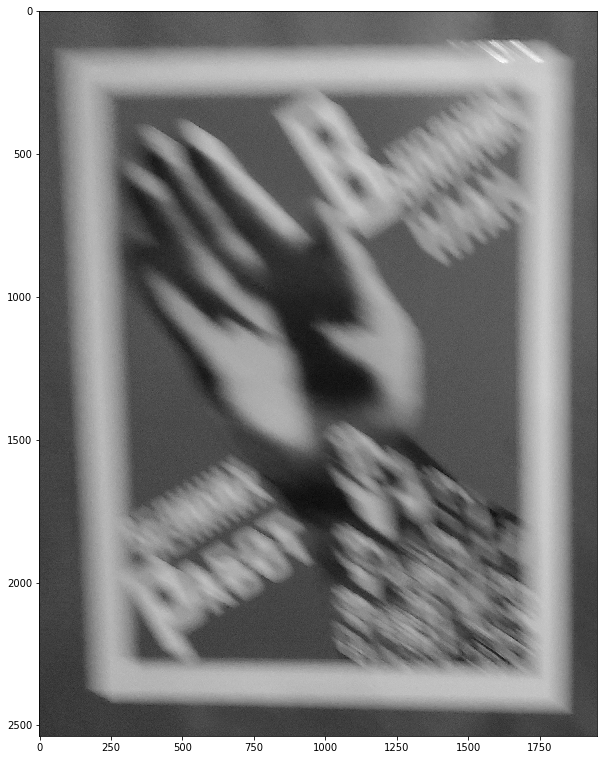

In [25]:
# filename = "mb0.jpg"
filename = "low_pig_rotated.jpg"
filename = "mb0_low.jpg"
filename = "cm.png"
filename = "q.jpg"
filename = "pl_l.jpg"

img = rgb2gray(plt.imread(work_dir + filename))

plt.figure(figsize=(10,230))
plt.imshow(img, cmap='gray')

In [26]:
%%time
c = Cepstrum(img, batch_size=256, step=0.5)
c.MainProcess()

# plt.imsave('big_img.png', c.conc_cepstrum_picture, cmap='gray')

if (DEBUG):
#     plt.imsave('lines_img.png', c.conc_lines_img, cmap='gray')

    d = blend_images('orig_img.png', 'big_img.png')
    d.save('temp_vis.png')
    
    d = blend_images('temp_vis.png', 'lines_img.png', alpha=0.2, colH = 120)
    d.save(save_dir + filename[:-4] +'_vis.png')

    d = blend_images('orig_img.png', 'lines_img.png', alpha=0.6, colH = 120)
    d.save(save_dir + filename[:-4] +'_lines.png')
    
    plt.imsave(save_dir + filename[:-4] + '_restored_img.png', c.restored_image_full, cmap='gray')
    gc.collect()

Counted cepstrums:  7.297755718231201


C:\Users\Admin\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
0.0 -1.5707963267948966
1.633123935319537e+16
90.0 0.0
-0.0
88.0 -0.03490658503988664
0.03492076949174778
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
57.0 -0.5759586531581288
0.6494075931975106
90.0 0.0
-0.0
90.0 0.0
-0.0
91.0 0.01745329251994332
-0.01745506492821761
90.0 0.0
-0.0
90.0 0.0
-0.0
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
90.0 0.0
-0.0
58.0 -0.5585053606381853
0.6248693519093274
57.0 -0.5759586531581288
0.6494075931975106
90.0 0.0
-0.0
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
90.0 0.0
-0.

52.0 -0.6632251157578452
0.7812856265067173
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
0.0 -1.5707963267948966
1.633123935319537e+16
34.0 -0.9773843811168245
1.4825609685127399
49.0 -0.7155849933176751
0.8692867378162266
0.0 -1.5707963267948966
1.633123935319537e+16
90.0 0.0
-0.0
90.0 0.0
-0.0
56.0 -0.593411945678072
0.6745085168424265
57.0 -0.5759586531581288
0.6494075931975106
56.0 -0.593411945678072
0.6745085168424265
58.0 -0.5585053606381853
0.6248693519093274
56.0 -0.593411945678072
0.6745085168424265
55.0 -0.6108652381980153
0.7002075382097097
55.0 -0.6108652381980153
0.7002075382097097
0.0 -1.5707963267948966
1.633123935319537e+16
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
90.0 0.0
-0.0
56.0 -0.593411945678072
0.6745085168424265
56.0 -0.593411945678072
0.6745085168424265
90.0 0.0
-0.0
55.0 -0.6108652381980153
0.7002075382097097
55.0 -0.6108652381980153
0.7002075382097097
0.0 -1.570796326794

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in greater


Counted lengths:  614.033264875412
Counted kernels:  614.0402626991272
Wall time: 10min 46s


-0.7002075382097097
-0.6108652381980153
-0.6108652381980153


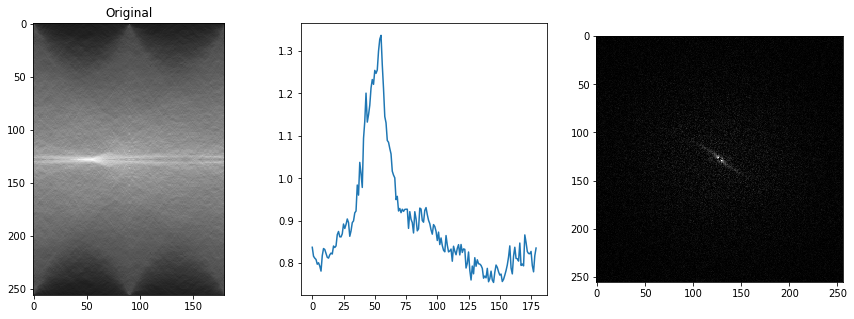

In [22]:
i = -2
image = tmp[i]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

sinogram = image.max(axis=0)
ax2.plot(sinogram)

ax3.imshow(c.cepstrum_picture[i], cmap='gray')
theta = np.linspace(0., 180., 180, endpoint=False)
if (DEBUG):
    angle = (theta[np.argmax(sinogram)] - 90) * math.pi/180
print(math.tan(angle))

print(angle)
print(c.angle[-1][-2])

In [122]:
print(list([theta[np.argmax(image.max(axis=0))] for image in tmp]))

[90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 0.0, 90.0, 88.0, 90.0, 90.0, 90.0, 90.0, 57.0, 90.0, 90.0, 91.0, 90.0, 90.0, 0.0, 0.0, 0.0, 90.0, 58.0, 57.0, 90.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 90.0, 0.0, 0.0, 0.0, 55.0, 59.0, 47.0, 0.0, 0.0, 0.0, 51.0, 90.0, 0.0, 48.0, 32.0, 0.0, 0.0, 0.0, 50.0, 34.0, 0.0, 47.0, 90.0, 0.0, 41.0, 90.0, 51.0, 55.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58.0, 90.0, 90.0, 46.0, 90.0, 90.0, 90.0, 39.0, 90.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 90.0, 90.0, 0.0, 90.0, 0.0, 90.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0, 60.0, 45.0, 90.0, 0.0, 0.0, 0.0, 90.0, 0.0, 90.0, 0.0, 179.0, 0.0, 16.0, 0.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.0, 0.0, 90.0, 0.0, 90.0, 0.0, 90.0, 0.0, 72.0, 0.0, 0.0, 0.0, 2.0, 0.0, 90.0, 0.0, 90.0, 0.0, 0.0, 90.0, 90.0, 0.0, 52.0, 0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 90.0, 90.0, 90.0, 52.0, 43.0, 57.0, 53.0, 91.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 56.0, 0.0, 0.0, 0.0, 55.0, 52.0, 56.0, 47.0, 0.0

In [ ]:
%%time
filenames = ['mb0.jpg', 'pig_lil.jpg']
# filenames = ['low_pig.jpg', 'mb0_low.jpg']
# filenames = ['pig_lil.jpg']

for filename in filenames:
    img = rgb2gray(plt.imread(work_dir + filename))
    c = Cepstrum(img, batch_size=256, step=0.5)
    c.ft_array()

    q = c.make_big_image()
    plt.imsave('big_img.png', q, cmap='gray')
    if (DEBUG):
        plt.imsave('lines_img.png', c.lines_img, cmap='gray')

        d = blend_images('orig_img.png', 'big_img.png')
        d.save('temp_vis.png')

        d = blend_images('temp_vis.png', 'lines_img.png', alpha=0.2, colH = 120)
        d.save(save_dir + filename[:-4] +'_vis.png')

        d = blend_images('orig_img.png', 'lines_img.png', alpha=0.6, colH = 120)
        d.save(save_dir + filename[:-4] +'_lines.png')
        
        plt.imsave(save_dir + filename[:-4] + '_restored_img.png', c.restored_image_full, cmap='gray')
        gc.collect()

Counted cepstrums:  17.987801790237427


In [47]:
img = rgb2gray(plt.imread('cm.png'))
k = rgb2gray(plt.imread('ne_large.png'))
k /= k.sum()
print(k.sum())
for i in range(30):
    img = restoration.richardson_lucy(img, k, iterations=1)
    img[img < 0] = 0
plt.imsave('jej.png', img, cmap='gray')

1.0
